## Importing necessary libraries

In [29]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation

import cleaningtools as ct
import pandas as pd

pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

np.int = np.int32

from mltools import CustomOrdinalEncoder, CustomCategoricalConverter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from feature_engine.encoding import OrdinalEncoder

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

from probatus.feature_elimination import ShapRFECV
import shap

shap.initjs()

from skopt import BayesSearchCV
from skopt.space import Real, Integer

import pickle

## Importing Train and Test sets from Data wrangling Notebook

In [2]:
PATH = "../Data/home-credit-default-risk"
train_set = pd.read_parquet(PATH+"/revolving_loans_train.parquet.gzip")
test_set = pd.read_parquet(PATH+"/revolving_loans_test.parquet.gzip")

In [3]:
train_set = ct.convert_types(train_set, print_info=True)
test_set = ct.convert_types(test_set, print_info=True)

Original Memory Usage: 0.1 gb.
New Memory Usage: 0.05 gb.
Original Memory Usage: 0.03 gb.
New Memory Usage: 0.01 gb.


In [4]:
# remove high cardinality categorical features
train_set = train_set.drop(columns=["occupation_type", "organization_type"])
test_set = test_set.drop(columns=["occupation_type", "organization_type"])
selected_col = [
    "cnt_fam_members",
    "cnt_children",
    "obs_30_cnt_social_circle",
    "def_30_cnt_social_circle",
    "obs_60_cnt_social_circle",
    "def_60_cnt_social_circle",
    "amt_req_credit_bureau_hour",
    "amt_req_credit_bureau_day",
    "amt_req_credit_bureau_week",
    "amt_req_credit_bureau_mon",
    "amt_req_credit_bureau_qrt",
    "amt_req_credit_bureau_year",
    "region_rating_client",
    "region_rating_client_w_city",
]
for col in selected_col:
    train_set[col] = train_set[col].astype("Int32")
    train_set[col] = train_set[col].astype("category")
    test_set[col] = test_set[col].astype("Int32")
    test_set[col] = test_set[col].astype("category")


In [5]:
X_train = train_set.drop("target", axis=1)
y_train = train_set["target"]

## Building the Pipeline

In [6]:
order = [
    "Lower secondary",
    "Secondary / secondary special",
    "Incomplete higher",
    "Higher education",
    "Academic degree",
]
order_2 = [
    "MONDAY",
    "TUESDAY",
    "WEDNESDAY",
    "THURSDAY",
    "FRIDAY",
    "SATURDAY",
    "SUNDAY",
]
cat_feat = X_train.select_dtypes("category").columns.tolist()
cat_feat.remove("name_education_type")
cat_feat.remove("weekday_appr_process_start")

preprocess_pipeline = ColumnTransformer(
    transformers=[
        (
            "custom_ordinal_encoder_1",
            CustomOrdinalEncoder(column_name="name_education_type", order=order),
            ["name_education_type"],
        ),
        (
            "custom_ordinal_encoder_2",
            CustomOrdinalEncoder(
                column_name="weekday_appr_process_start", order=order_2
            ),
            ["weekday_appr_process_start"],
        ),
        (
            "cat_encoding",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
            cat_feat,
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
preprocess_pipeline.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('custom_ordinal_encoder_1',
                                 CustomOrdinalEncoder(column_name='name_education_type',
                                                      order=['Lower secondary',
                                                             'Secondary / '
                                                             'secondary '
                                                             'special',
                                                             'Incomplete '
                                                             'higher',
                                                             'Higher education',
                                                             'Academic '
                                                             'degree']),
                                 ['name_education_type']),
                                ('custom_ordinal_encoder_2',
                                 CustomOrdinalEncoder(column_name='weekday...
                                  'reg_region_not_live_region',
                                  'reg_region_not_work_region',
                                  'live_region_not_work_region',
                                  'reg_city_not_live_city',
                                  'reg_city_not_work_city',
                                  'live_city_not_work_city',
                                  'obs_30_cnt_social_circle',
                                  'def_30_cnt_social_circle',
                                  'obs_60_cnt_social_circle',
                                  'def_60_cnt_social_circle', 'flag_document_3',
                                  'flag_document_4', 'flag_document_5', ...])],
                  verbose_feature_names_out=False)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [8]:
pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_feat),
        ),
    ]
)
X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

MODEL EVALUATION ON TRAINING SET


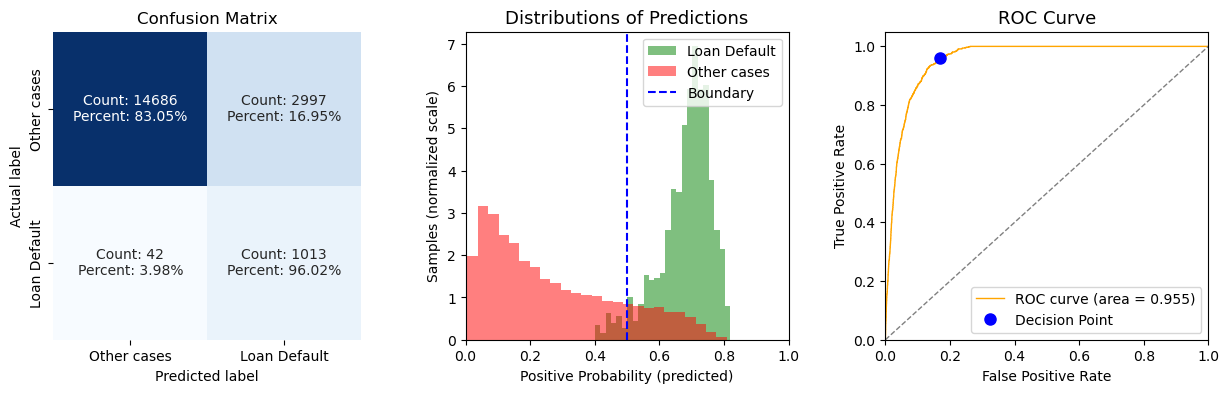

Precision: 0.253 | Recall: 0.96 | F1 Score: 0.4 | AUC: 0.955
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


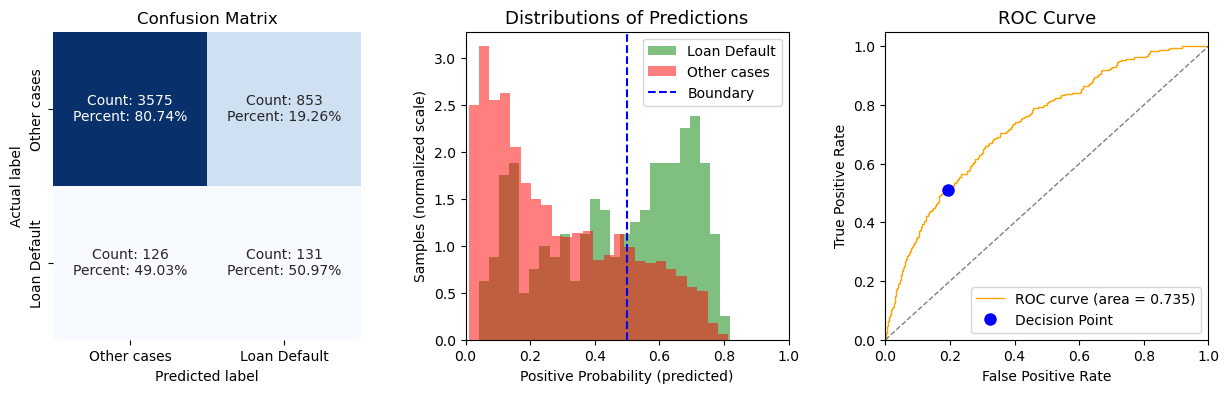

Precision: 0.133 | Recall: 0.51 | F1 Score: 0.211 | AUC: 0.735
------------------------------------------------------------------


In [9]:
weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
classifier = LGBMClassifier(
    random_state=1,
    scale_pos_weight=weight,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
)

classifier.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict_proba(X_train_transformed)
f.binary_performances(
    y_train,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
)
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict_proba(X_valid_transformed)
f.binary_performances(
    y_valid,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
)
print("------------------------------------------------------------------")

From the initial evaluation of our model we can see that there is a big overfitting problem so I will run hyperparameter tuning and recursive feature elimination to try to solve this problem.

In [10]:
param_space = {
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "n_estimators": Integer(50, 200),
    "scale_pos_weight": Integer(1, 20),
    "min_child_samples": Integer(0, 50),
    "max_depth": Integer(1, 10),
    "num_leaves": Integer(2, 100),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.3, 1.0, "uniform"),
    "min_gain_to_split": Real(0.0, 1.0, "uniform"),
    "reg_lambda": Real(1e-8, 1000, "log-uniform"),
}
opt = BayesSearchCV(
    classifier,
    param_space,
    scoring="roc_auc",
    n_iter=20,
    cv=3,
    verbose=0,
)
shap_elimination = ShapRFECV(clf=opt, step=0.2, scoring="roc_auc", n_jobs=-1, verbose=0)
report = shap_elimination.fit_compute(
    X_train_transformed,
    y_train,
    check_additivity=False,
    classifier__eval_set=[(X_valid_transformed, y_valid)],
    classifier__callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)

In [12]:
report[["num_features", "features_set", "val_metric_mean"]]

,num_features,features_set,val_metric_mean
1,542,"[name_education_type, weekday_appr_process_sta...",0.750
2,434,"[name_education_type, weekday_appr_process_sta...",0.749
3,348,"[name_education_type, weekday_appr_process_sta...",0.753
4,279,"[name_education_type, weekday_appr_process_sta...",0.751
5,224,"[name_education_type, weekday_appr_process_sta...",0.757
6,180,"[name_education_type, weekday_appr_process_sta...",0.749
7,144,"[name_education_type, weekday_appr_process_sta...",0.747
8,116,"[name_education_type, flag_work_phone, obs_30_...",0.749
9,93,"[name_education_type, flag_work_phone, obs_30_...",0.753
10,75,"[name_education_type, flag_work_phone, obs_30_...",0.752


In [13]:
final_features_set = shap_elimination.get_reduced_features_set(num_features=21)
features_to_drop = [
    col for col in X_train_transformed.columns if col not in final_features_set
]
X_train_transformed.drop(features_to_drop, axis=1, inplace=True)
X_valid_transformed.drop(features_to_drop, axis=1, inplace=True)

In [14]:
opt.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)

BayesSearchCV(cv=3,
              estimator=LGBMClassifier(force_col_wise=True, metric='auc',
                                       num_threads=8, objective='binary',
                                       random_state=1,
                                       scale_pos_weight=16.761137440758294,
                                       verbosity=-1),
              n_iter=20, scoring='roc_auc',
              search_spaces={'colsample_bytree': Real(low=0.3, high=1.0, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=1.0, prior='log-un...
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=2, high=100, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=1e-08, high=1000, prior='log-uniform', transform='normalize'),
                             'scale_pos_weight': Integer(low=1, high=20, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.01, high=1.0, prior='uniform', transform='normalize')})

MODEL EVALUATION ON TRAINING SET


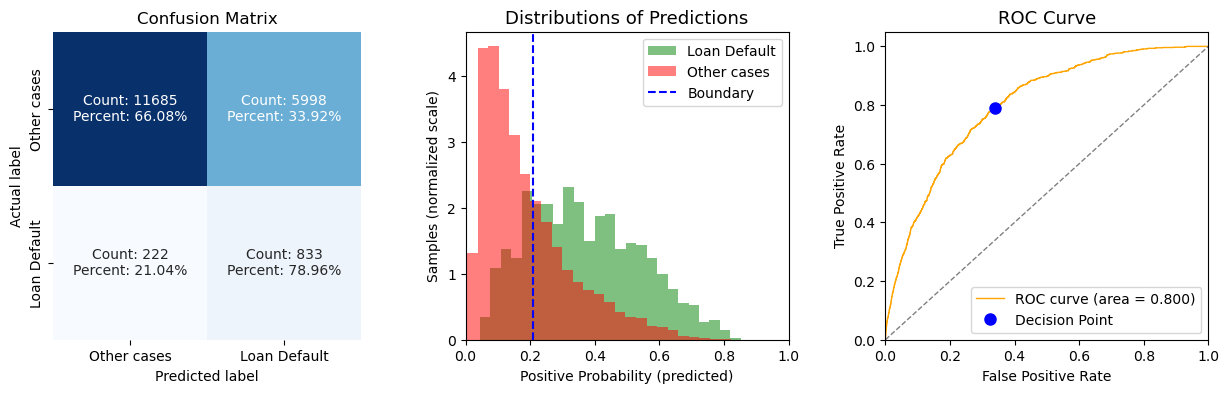

Precision: 0.122 | Recall: 0.79 | F1 Score: 0.211 | AUC: 0.8
------------------------------------------------------------------
MODEL EVALUATION ON VALIDATION SET


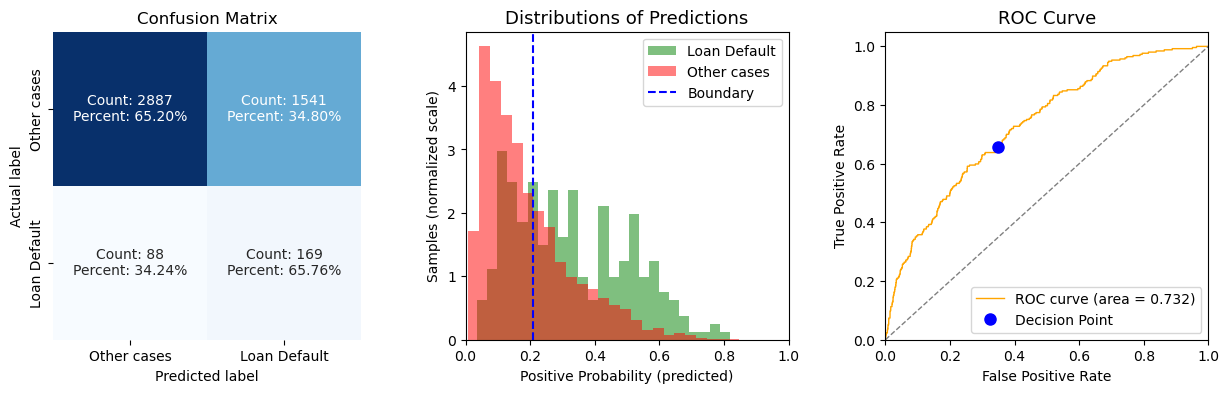

Precision: 0.099 | Recall: 0.658 | F1 Score: 0.172 | AUC: 0.732
------------------------------------------------------------------


In [17]:
classifier = LGBMClassifier(
    random_state=1,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
    **opt.best_params_
)

classifier.fit(
    X_train_transformed,
    y_train,
    eval_set=[(X_valid_transformed, y_valid)],
    callbacks=[log_evaluation(0), early_stopping(20, verbose=False)],
)
print("MODEL EVALUATION ON TRAINING SET")
y_pred = classifier.predict_proba(X_train_transformed)
f.binary_performances(
    y_train,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.21,
)
print("------------------------------------------------------------------")
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = classifier.predict_proba(X_valid_transformed)
f.binary_performances(
    y_valid,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.21,
)
print("------------------------------------------------------------------")

## Calibrating the model

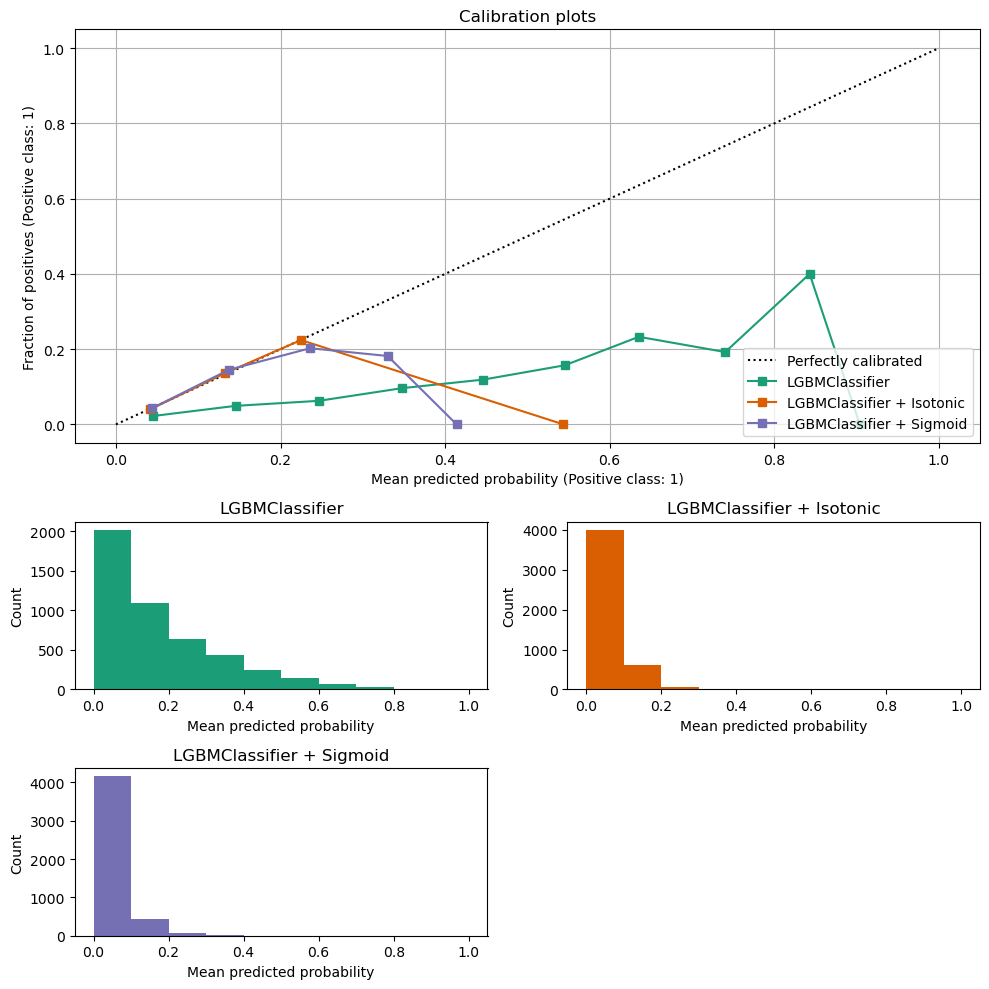

In [19]:
classifier = LGBMClassifier(
    random_state=1,
    objective="binary",
    metric="auc",
    force_col_wise=True,
    num_threads=8,
    verbosity=-1,
    **opt.best_params_
)
lgbm_isotonic = CalibratedClassifierCV(classifier, cv=2, method="isotonic")
lgbm_sigmoid = CalibratedClassifierCV(classifier, cv=2, method="sigmoid")

clf_list = [
    (classifier, "LGBMClassifier"),
    (lgbm_isotonic, "LGBMClassifier + Isotonic"),
    (lgbm_sigmoid, "LGBMClassifier + Sigmoid"),
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train_transformed, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_valid_transformed,
        y_valid,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Final pipeline

In [22]:
cat_feat = [
    "mode_previous_application_name_goods_category",
    "mode_pos_cash_balance_previous_application_name_goods_category",
    "mode_installments_payments_previous_application_product_combination",
]
best_params = {
    "colsample_bytree": 0.9591033994242415,
    "learning_rate": 0.26837141863065855,
    "max_depth": 9,
    "min_child_samples": 8,
    "min_gain_to_split": 0.8527653603093815,
    "n_estimators": 192,
    "num_leaves": 4,
    "reg_lambda": 1.311605661447668e-08,
    "scale_pos_weight": 5,
    "subsample": 0.9847032478770692,
}
features_to_drop = [col for col in X_train.columns if col not in final_features_set]
X_train.drop(features_to_drop, axis=1, inplace=True)

In [23]:
pre_pipeline = ColumnTransformer(
    transformers=[
        (
            "custom_ordinal_encoder",
            CustomOrdinalEncoder(column_name="name_education_type", order=order),
            ["name_education_type"],
        ),
        (
            "cat_encoder",
            OrdinalEncoder(
                encoding_method="arbitrary", missing_values="ignore", unseen="encode"
            ),
            cat_feat,
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
pre_pipeline.set_output(transform="pandas")
final_pipeline = Pipeline(
    steps=[
        ("preprocess", pre_pipeline),
        (
            "convert_to_categorical",
            CustomCategoricalConverter(columns_to_convert=cat_feat),
        ),
        (
            "calibrated_classifier",
            CalibratedClassifierCV(classifier, cv=2, method="isotonic"),
        ),
    ]
)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('custom_ordinal_encoder',
                                                  CustomOrdinalEncoder(column_name='name_education_type',
                                                                       order=['Lower '
                                                                              'secondary',
                                                                              'Secondary '
                                                                              '/ '
                                                                              'secondary '
                                                                              'special',
                                                                              'Incomplete '
                                                                              'higher',
                                                                              'Higher '
                                                                              'education',
                                                                              'Academic '
                                                                              'degree']),
                                                  ['name_education_type']),
                                                 ('cat_encoder',
                                                  OrdinalEncoder(encod...
                                        estimator=LGBMClassifier(colsample_bytree=0.9591033994242415,
                                                                 force_col_wise=True,
                                                                 learning_rate=0.26837141863065855,
                                                                 max_depth=9,
                                                                 metric='auc',
                                                                 min_child_samples=8,
                                                                 min_gain_to_split=0.8527653603093815,
                                                                 n_estimators=192,
                                                                 num_leaves=4,
                                                                 num_threads=8,
                                                                 objective='binary',
                                                                 random_state=1,
                                                                 reg_lambda=1.311605661447668e-08,
                                                                 scale_pos_weight=5,
                                                                 subsample=0.9847032478770692,
                                                                 verbosity=-1),
                                        method='isotonic'))])

MODEL EVALUATION ON VALIDATION SET


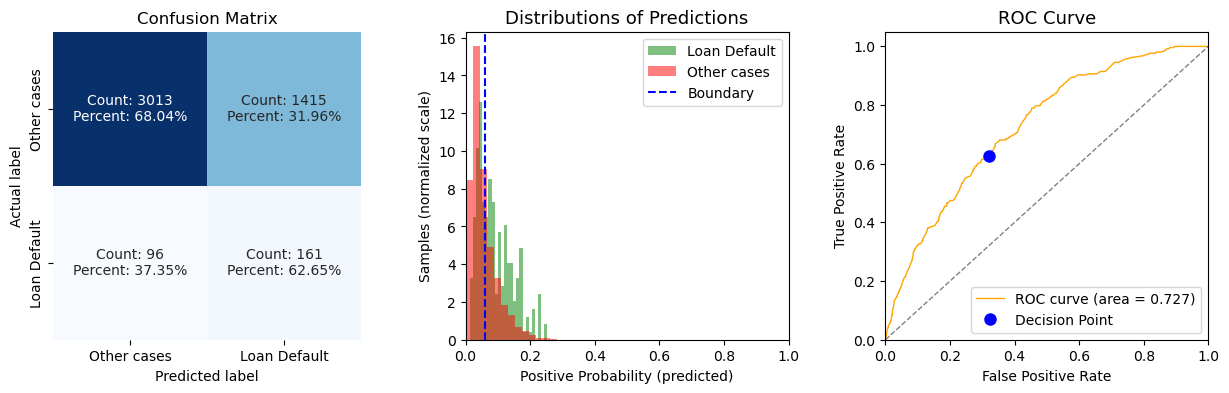

Precision: 0.102 | Recall: 0.626 | F1 Score: 0.176 | AUC: 0.727


In [26]:
print("MODEL EVALUATION ON VALIDATION SET")
y_pred = final_pipeline.predict_proba(X_valid)
f.binary_performances(
    y_valid,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.06,
)

## Final evaluation on Test set

In [27]:
X_test = test_set.drop("target", axis=1)
y_test = test_set["target"]
X_test.drop(features_to_drop, axis=1, inplace=True)

MODEL EVALUATION ON TEST SET


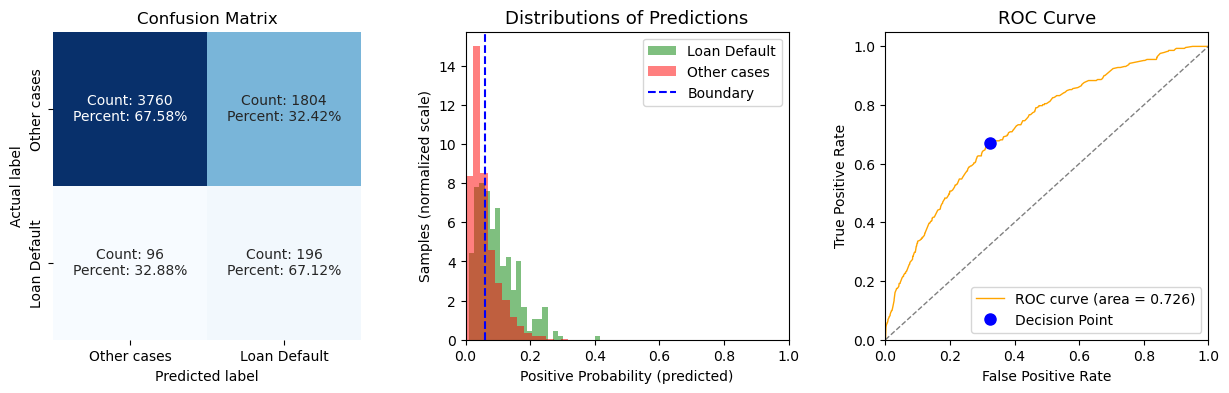

Precision: 0.098 | Recall: 0.671 | F1 Score: 0.171 | AUC: 0.726


In [28]:
print("MODEL EVALUATION ON TEST SET")
y_pred = final_pipeline.predict_proba(X_test)
f.binary_performances(
    y_test,
    y_pred,
    categories=["Other cases", "Loan Default"],
    labels=["Loan Default", "Other cases"],
    thresh=0.06,
)

In [24]:
final_pipeline.score(X_test, y_test)

0.8907103825136612

Now we can calculate how much money our model would prevent the bank from losing by default loans. This could be achieved by multiplying the number of TP (True Positives) by the average credit amount of the default loans group which is 255k. As a result we get **50 million** in total. Also we can approximate the amount of money the bank will lose if there are a lot of misclassified default loans (False positives). This could be achieved by multiplying the number of FP by the average credit amount of the non-default loans group which is 327k and also the interest rate which could be 15% in this case. So as a result we get **88 million** of profit that could be lost due to misclassification. So this model can't be considered for a real business use yet because it would generate to much losses for the bank. It needs to be improved or the alternative approach is needed.

## Saving the final model

In [ ]:
# with open("revolving_loan_default-0.1.0.pkl", "wb") as f:
#     pickle.dump(final_pipeline, f)